# `AZDIAS` + `CUSTOMERS` dataset

# 00. Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from eda_utils import *

# 01. Loading datasets

In [2]:
customers = pd.read_csv("../arvato_data_processed/customers.csv", low_memory = False, index_col = 'LNR')
azdias = pd.read_csv("../arvato_data_processed/azdias.csv", low_memory = False, index_col = 'LNR')

customers_feature_types =  pd.read_csv("../arvato_data_processed/customers_feature_types.csv", low_memory = False,index_col='Attribute' )
azdias_feature_types =  pd.read_csv("../arvato_data_processed/azdias_feature_types.csv", low_memory = False,index_col='Attribute' )

print(customers_feature_types.shape,azdias_feature_types.shape)

customers_features = set(customers_feature_types['Attribute.1'])
azdias_features = set(azdias_feature_types['Attribute.1']) 

(333, 2) (332, 2)


# 02. Common features

In [3]:
common_features=  customers_features.intersection(azdias_features)
len(common_features)

330

We have 330 features in common, let's see what features are missing. We know from previous notebooks that `customers` initially had 3 more features than `azdias` dataset:

In [4]:
customers_features.difference(azdias_features)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [5]:
azdias_features.difference(customers_features)

{'KKK', 'REGIOTYP'}

So, after applying filtering for missingness in `azdias` and `customers` we have 330 common features.

Three features present in `customers` are lacking entires in `azdias`:
1. `CUSTOMER_GROUP`
2. `ONLINE_PURCHASE`
3. `PRODUCT_GROUP`

These features are related to the customer-related information for which we **naturally don't have general population equivalent**: 1. what is the group of the customer (single/multiple buyer), 2. whether it bought something online from us, 3. what category of product was it

Whereas customers lack two features present in general population:

1. `KKK` - purchasing power
2. `REGIOTYP` - neighbourhood, one of several possible classes: unknown, upper class, conservatives, upper middle class, middle class, lower middle class, traditional workers, marginal groups

In [6]:
azdias = azdias[common_features]
customers = customers[common_features]

In [7]:
customers['dataset'] = 'customers'
azdias['dataset'] = 'azdias'

In [8]:
joint_dataset = pd.concat([customers,azdias])
assert customers.shape[0]+azdias.shape[0]==joint_dataset.shape[0]

joint_dataset.head(5)

,KBA13_SEG_SPORTWAGEN,KBA05_MAXSEG,W_KEIT_KIND_HH,KBA13_HALTER_60,CJT_TYP_6,KBA13_BJ_2004,UNGLEICHENN_FLAG,KBA13_KW_0_60,KBA05_MOD1,KBA13_SEG_KLEINST,...,ANZ_HAUSHALTE_AKTIV,KBA13_SEG_MINIVANS,ZABEOTYP,KBA05_KRSHERST1,KBA05_MAXHERST,FINANZ_MINIMALIST,BALLRAUM,KBA13_SITZE_6,KBA13_HALTER_30,dataset
LNR,,,,,,,,,,,,,,,,,,,,,
9626,4.0,3.0,6.0,5.0,5.0,3.0,0.0,3.0,2.0,2.0,...,1.0,3.0,3,4.0,2.0,5,3.0,5.0,1.0,customers
143872,3.0,2.0,6.0,3.0,5.0,1.0,0.0,4.0,2.0,4.0,...,1.0,2.0,3,4.0,2.0,5,7.0,4.0,4.0,customers
143873,4.0,1.0,NaN,3.0,5.0,3.0,0.0,2.0,0.0,1.0,...,0.0,4.0,1,4.0,4.0,5,7.0,3.0,3.0,customers
143874,3.0,2.0,2.0,3.0,3.0,3.0,0.0,4.0,1.0,4.0,...,7.0,4.0,1,2.0,2.0,3,3.0,3.0,1.0,customers
143888,3.0,4.0,6.0,2.0,5.0,3.0,0.0,2.0,4.0,2.0,...,1.0,2.0,2,3.0,2.0,5,7.0,5.0,3.0,customers


In [9]:
# free memory
del customers
del azdias

# TODO: PCA on joint dataset

There is some systematic drift between customers and azdias. Find it, eliminate it.

# 03. Features

## 03.01. Standardizing features

Upon inspecting metadata attributes in `DIAS Attributes - Values 2017.xlsx` I've found that there are a couple of features that need re-encoding:

- `LP_FAMILIE_GROB` must be standardized. As initially there are multiple labels that refer to the same class!
    - from documentation: 
     ```
     1 -> single
     2 - > couple
     3,4,5 -> single parent
     6,7,8 -> family
     9,10,11 -> multiperson household
     
     ```
     
     
I will replace all secondary values for a class with the first value of a class. Also, there seems to be a value `0` present, but for which we don't have any information, I'll replace `0` with NA

In [10]:

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


joint_dataset['LP_FAMILIE_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(7,6,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(8,6,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(10,9,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(11,9,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(0,np.nan,inplace=True)


print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


Before standarization we have classes: [0. 1. 2. 3. 4. 5.]
After standarization we have classes: [1. 2. 3.]


- `LP_STATUS_GROB` is a feature that encodes the same class with different labels. From the provided metadata in Exel file we know:
   ```
   1,2 - > low-income earners
   3,4,5 -> average,erners
   6,7 -> independants
   8,9 -> houseowners
   10 -> top earners
   
   ```
   

In [11]:
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))

joint_dataset['LP_STATUS_GROB'].replace(2,1,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_STATUS_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(7,6,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(9,8,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))


Before standarization we have classes: [1. 2. 3. 4. 5.]
After standarization we have classes: [1. 3.]


- `PRAEGENDE_JUGENDJAHRE` could be simplified, thus I create a new feature: `PRAEGENDE_JUGENDJAHRE_SIM` to collapse a couple of classes together based on metadata:


initial classes:
```
1	40ies - war years (Mainstream, O+W)
2	40ies - reconstruction years (Avantgarde, O+W)
3	50ies - economic miracle (Mainstream, O+W)
4	50ies - milk bar / Individualisation (Avantgarde, O+W)
5	60ies - economic miracle (Mainstream, O+W)
6	60ies - generation 68 / student protestors (Avantgarde, W)
7	60ies - opponents to the building of the Wall (Avantgarde, O)
8	70ies - family orientation (Mainstream, O+W)
9	70ies - peace movement (Avantgarde, O+W)
10	80ies - Generation Golf (Mainstream, W)
11	80ies - ecological awareness (Avantgarde, W)
12	80ies - FDJ / communist party youth organisation (Mainstream, O)
13	80ies - Swords into ploughshares (Avantgarde, O)
14	90ies - digital media kids (Mainstream, O+W)
15	90ies - ecological awareness (Avantgarde, O+W)
```
simplified classes:

```
    1,2 -> 40ies
    3,4 -> 50ies
    5,6,7 -> 60ies
    8,9 -> 70ies
    10,11,12,13 -: 80ies
    14,15 -> 90ies

```


In [12]:
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM']= joint_dataset['PRAEGENDE_JUGENDJAHRE']

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE'].dropna())))

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(2,1,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(4,3,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(6,5,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(7,5,inplace=True)
 
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(9,8,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace([11,12,13],10,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(15,14,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].dropna())))


Before standarization we have classes: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
After standarization we have classes: [ 1.  3.  5.  8. 10. 14.]


- `CAMEO_DEUINTL_2015` can be also generalized/simplified: to `CAMEO_DEUINTL_2015_SIM`

original annotations
```
11	Wealthy Households-Pre-Family Couples & Singles
12	Wealthy Households-Young Couples With Children
13	Wealthy Households-Families With School Age Children
14	Wealthy Households-Older Families &  Mature Couples
15	Wealthy Households-Elders In Retirement
21	Prosperous Households-Pre-Family Couples & Singles
22	Prosperous Households-Young Couples With Children
23	Prosperous Households-Families With School Age Children
24	Prosperous Households-Older Families & Mature Couples
25	Prosperous Households-Elders In Retirement
31	Comfortable Households-Pre-Family Couples & Singles
32	Comfortable Households-Young Couples With Children
33	Comfortable Households-Families With School Age Children
34	Comfortable Households-Older Families & Mature Couples
35	Comfortable Households-Elders In Retirement
41	Less Affluent Households-Pre-Family Couples & Singles
42	Less Affluent Households-Young Couples With Children
43	Less Affluent Households-Families With School Age Children
44	Less Affluent Households-Older Families & Mature Couples
45	Less Affluent Households-Elders In Retirement
51	Poorer Households-Pre-Family Couples & Singles
52	Poorer Households-Young Couples With Children
53	Poorer Households-Families With School Age Children
54	Poorer Households-Older Families & Mature Couples
55	Poorer Households-Elders In Retirement

```

simplified:

```
11,12,13,14,15 -> wealthy

21,22,23,24,25 -> prosperous

31,32,33,34,35 -> comfortable

41,42,43,44,45 -> less affluent

51,52,53,54,55 -> poorer

```

also, the `XX` is replaced as unknown:

In [13]:
joint_dataset['CAMEO_DEUINTL_2015_SIM'] = joint_dataset['CAMEO_DEUINTL_2015']

 
    
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('12','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('13','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('14','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('15','11',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('22','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('23','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('24','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('25','21',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('32','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('33','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('34','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('35','31',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('42','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('43','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('44','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('45','41',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('52','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('53','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('54','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('55','51',inplace=True)
    
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('XX',np.nan,inplace=True)    
    
print("After standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))


Before standarization we have classes: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']
After standarization we have classes: ['11' '21' '31' '41' '51']


- encode (check types)
- impute
- correlate
- save independent?

## 03.02. Encode Features

joint dataset comprises of three types of features: 

1. numerical - will be left unchanged
2. ordinal - will be encoded with label encoder
3. categorical -> will be encoded with label encoder


I will encode ordinal and categorical features as standardized integers. As seen above some classes comprise of high-value numbers.

In [15]:
# Assert that the feature types in AZDIAS and Customers are the same for ALL
common_features = pd.merge(customers_feature_types,azdias_feature_types,on='Attribute.1')
assert common_features[common_features['Type_x']!=common_features["Type_y"]].shape[0]==0


Extract feature names that **ARE NOT NUMERICAL** (that need label encoding)

In [16]:
str_features = list(common_features[common_features['Type_x']!='numerical']['Attribute.1'])

# two newly created features
str_features.append('PRAEGENDE_JUGENDJAHRE_SIM')
str_features.append('CAMEO_DEUINTL_2015_SIM')
str_features = list(set(str_features))
len(str_features)

324

In [17]:
joint_dataset.shape

(932108, 333)

In [18]:
from sklearn.preprocessing import LabelEncoder
LabelEncoders = { x: LabelEncoder() for x in str_features  }

CPU times: user 1.09 s, sys: 160 ms, total: 1.25 s
Wall time: 1.25 s


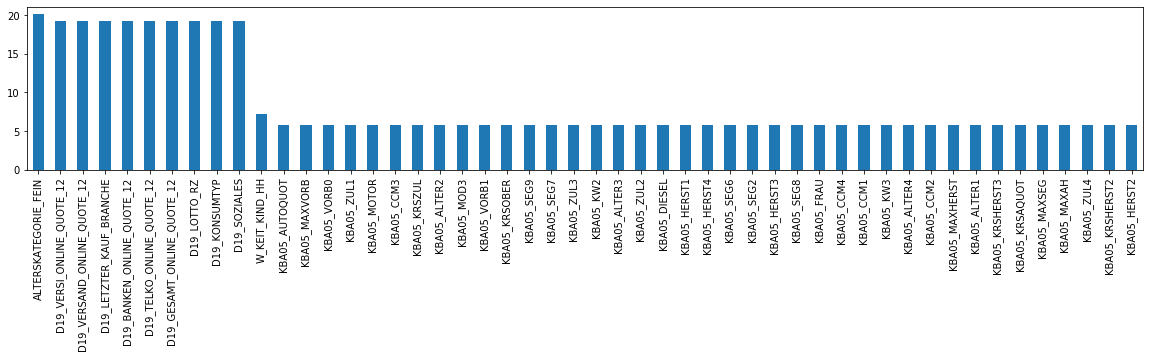

In [19]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [20]:
joint_dataset.shape

(932108, 333)

In [21]:
for idx,feature in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),feature ))
    
    not_na_mask =  joint_dataset[feature].notnull()
    
    joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )

1/324: KBA05_MAXSEG
2/324: KBA13_SEG_SPORTWAGEN
3/324: W_KEIT_KIND_HH


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4/324: KBA13_HALTER_60
5/324: CJT_TYP_6
6/324: KBA13_BJ_2004
7/324: UNGLEICHENN_FLAG
8/324: KBA13_KW_0_60
9/324: KBA05_MOD1
10/324: FINANZ_SPARER
11/324: CJT_TYP_4
12/324: KBA13_SEG_KLEINST
13/324: HH_DELTA_FLAG
14/324: D19_ENERGIE_RZ
15/324: EWDICHTE
16/324: KBA05_ZUL4
17/324: KBA05_KRSAQUOT
18/324: KBA05_KRSHERST2
19/324: D19_VERSAND_ONLINE_QUOTE_12
20/324: KBA13_BAUMAX
21/324: KBA13_BMW
22/324: KBA05_HERSTTEMP
23/324: SEMIO_KRIT
24/324: D19_VOLLSORTIMENT_RZ
25/324: SEMIO_LUST
26/324: KBA05_MAXBJ
27/324: KBA13_KW_110
28/324: D19_KONSUMTYP
29/324: D19_BANKEN_DIREKT_RZ
30/324: VK_DISTANZ
31/324: KBA13_SITZE_4
32/324: KBA05_MOD2
33/324: EINGEZOGENAM_HH_JAHR
34/324: ALTERSKATEGORIE_FEIN
35/324: KBA13_ALTERHALTER_45
36/324: LP_FAMILIE_FEIN
37/324: D19_BIO_OEKO_RZ
38/324: KBA13_KMH_140
39/324: D19_NAHRUNGSERGAENZUNG_RZ
40/324: KBA13_HALTER_66
41/324: GEMEINDETYP
42/324: KBA13_RENAULT
43/324: KBA13_HERST_EUROPA
44/324: KBA13_HERST_ASIEN
45/324: KBA13_HALTER_45
46/324: KBA13_HERST_FORD_OPEL


In [22]:
joint_dataset.shape

(932108, 333)

CPU times: user 983 ms, sys: 200 ms, total: 1.18 s
Wall time: 1.18 s


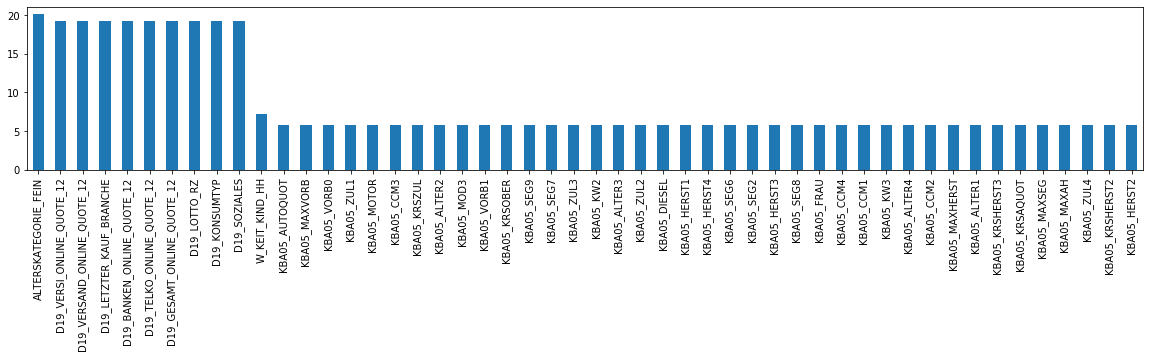

In [23]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

## 03.02 Impute features

In [24]:
joint_dataset.drop('dataset',inplace=True,axis='columns')

In [25]:
%%time
import sklearn 
from sklearn.experimental import enable_iterative_imputer
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.impute import IterativeImputer

ie = IterativeImputer(n_nearest_features=3) # 10 is fine

joint_dataset_imputed = ie.fit_transform(joint_dataset) # ~20min, returns numpy array
joint_dataset_imputed_df = pd.DataFrame(joint_dataset_imputed, columns= joint_dataset.columns )
joint_dataset_imputed_df.to_csv("../arvato_data_processed/joint_dataset_imputed.csv")

The scikit-learn version is 0.22.1.


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


CPU times: user 30min 4s, sys: 1min 32s, total: 31min 37s
Wall time: 13min 3s


In [26]:
joint_dataset_imputed_df =  pd.read_csv("../arvato_data_processed/joint_dataset_imputed.csv", low_memory = False )

In [27]:
for i,feature in enumerate(str_features):
    print("{}/{} {}".format(i+1,len(str_features), feature))
    joint_dataset_imputed_df[feature] = joint_dataset_imputed_df[feature].round()

1/324 KBA05_MAXSEG
2/324 KBA13_SEG_SPORTWAGEN
3/324 W_KEIT_KIND_HH
4/324 KBA13_HALTER_60
5/324 CJT_TYP_6
6/324 KBA13_BJ_2004
7/324 UNGLEICHENN_FLAG
8/324 KBA13_KW_0_60
9/324 KBA05_MOD1
10/324 FINANZ_SPARER
11/324 CJT_TYP_4
12/324 KBA13_SEG_KLEINST
13/324 HH_DELTA_FLAG
14/324 D19_ENERGIE_RZ
15/324 EWDICHTE
16/324 KBA05_ZUL4
17/324 KBA05_KRSAQUOT
18/324 KBA05_KRSHERST2
19/324 D19_VERSAND_ONLINE_QUOTE_12
20/324 KBA13_BAUMAX
21/324 KBA13_BMW
22/324 KBA05_HERSTTEMP
23/324 SEMIO_KRIT
24/324 D19_VOLLSORTIMENT_RZ
25/324 SEMIO_LUST
26/324 KBA05_MAXBJ
27/324 KBA13_KW_110
28/324 D19_KONSUMTYP
29/324 D19_BANKEN_DIREKT_RZ
30/324 VK_DISTANZ
31/324 KBA13_SITZE_4
32/324 KBA05_MOD2
33/324 EINGEZOGENAM_HH_JAHR
34/324 ALTERSKATEGORIE_FEIN
35/324 KBA13_ALTERHALTER_45
36/324 LP_FAMILIE_FEIN
37/324 D19_BIO_OEKO_RZ
38/324 KBA13_KMH_140
39/324 D19_NAHRUNGSERGAENZUNG_RZ
40/324 KBA13_HALTER_66
41/324 GEMEINDETYP
42/324 KBA13_RENAULT
43/324 KBA13_HERST_EUROPA
44/324 KBA13_HERST_ASIEN
45/324 KBA13_HALTER_45
46/32

# TODO
- save the scalers

In [28]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/324: KBA05_MAXSEG
2/324: KBA13_SEG_SPORTWAGEN
3/324: W_KEIT_KIND_HH
4/324: KBA13_HALTER_60
5/324: CJT_TYP_6
6/324: KBA13_BJ_2004
7/324: UNGLEICHENN_FLAG
8/324: KBA13_KW_0_60
9/324: KBA05_MOD1
10/324: FINANZ_SPARER
11/324: CJT_TYP_4
12/324: KBA13_SEG_KLEINST
13/324: HH_DELTA_FLAG
14/324: D19_ENERGIE_RZ
15/324: EWDICHTE
16/324: KBA05_ZUL4
17/324: KBA05_KRSAQUOT
18/324: KBA05_KRSHERST2
19/324: D19_VERSAND_ONLINE_QUOTE_12
20/324: KBA13_BAUMAX
21/324: KBA13_BMW
22/324: KBA05_HERSTTEMP
23/324: SEMIO_KRIT
24/324: D19_VOLLSORTIMENT_RZ
25/324: SEMIO_LUST
26/324: KBA05_MAXBJ
27/324: KBA13_KW_110
28/324: D19_KONSUMTYP
29/324: D19_BANKEN_DIREKT_RZ
30/324: VK_DISTANZ
31/324: KBA13_SITZE_4
32/324: KBA05_MOD2
33/324: EINGEZOGENAM_HH_JAHR
34/324: ALTERSKATEGORIE_FEIN
35/324: KBA13_ALTERHALTER_45
36/324: LP_FAMILIE_FEIN
37/324: D19_BIO_OEKO_RZ
38/324: KBA13_KMH_140
39/324: D19_NAHRUNGSERGAENZUNG_RZ
40/324: KBA13_HALTER_66
41/324: GEMEINDETYP
42/324: KBA13_RENAULT
43/324: KBA13_HERST_EUROPA
44/324: KB

,Attribute,Before_imputation,After_imputation
197,VERDICHTUNGSRAUM,46,46
249,CAMEO_DEU_2015,45,45
295,LP_LEBENSPHASE_FEIN,41,41
32,EINGEZOGENAM_HH_JAHR,37,37
130,D19_LETZTER_KAUF_BRANCHE,35,35
...,...,...,...
254,KONSUMZELLE,2,2
62,ANREDE_KZ,2,2
6,UNGLEICHENN_FLAG,2,2
217,DSL_FLAG,2,2


In [29]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation
52,D19_GESAMT_ONLINE_QUOTE_12,11,17
18,D19_VERSAND_ONLINE_QUOTE_12,11,18
284,PLZ8_BAUMAX,5,6
162,KBA05_ANTG1,5,7
179,KBA05_DIESEL,5,6


In [36]:
# replace seemingly new classes with NANs
for idx,feature in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),feature))
    imputed_clusters = np.unique(joint_dataset_imputed_df[feature].dropna())
    original_clusters = np.unique(joint_dataset[feature].dropna())


    unobserved_classes = set(imputed_clusters).difference( set(original_clusters) )
    for uclass in unobserved_classes:
        joint_dataset_imputed_df[feature].replace(uclass,np.nan, inplace=True)
        

1/324: KBA05_MAXSEG
2/324: KBA13_SEG_SPORTWAGEN
3/324: W_KEIT_KIND_HH
4/324: KBA13_HALTER_60
5/324: CJT_TYP_6
6/324: KBA13_BJ_2004
7/324: UNGLEICHENN_FLAG
8/324: KBA13_KW_0_60
9/324: KBA05_MOD1
10/324: FINANZ_SPARER
11/324: CJT_TYP_4
12/324: KBA13_SEG_KLEINST
13/324: HH_DELTA_FLAG
14/324: D19_ENERGIE_RZ
15/324: EWDICHTE
16/324: KBA05_ZUL4
17/324: KBA05_KRSAQUOT
18/324: KBA05_KRSHERST2
19/324: D19_VERSAND_ONLINE_QUOTE_12
20/324: KBA13_BAUMAX
21/324: KBA13_BMW
22/324: KBA05_HERSTTEMP
23/324: SEMIO_KRIT
24/324: D19_VOLLSORTIMENT_RZ
25/324: SEMIO_LUST
26/324: KBA05_MAXBJ
27/324: KBA13_KW_110
28/324: D19_KONSUMTYP
29/324: D19_BANKEN_DIREKT_RZ
30/324: VK_DISTANZ
31/324: KBA13_SITZE_4
32/324: KBA05_MOD2
33/324: EINGEZOGENAM_HH_JAHR
34/324: ALTERSKATEGORIE_FEIN
35/324: KBA13_ALTERHALTER_45
36/324: LP_FAMILIE_FEIN
37/324: D19_BIO_OEKO_RZ
38/324: KBA13_KMH_140
39/324: D19_NAHRUNGSERGAENZUNG_RZ
40/324: KBA13_HALTER_66
41/324: GEMEINDETYP
42/324: KBA13_RENAULT
43/324: KBA13_HERST_EUROPA
44/324: KB

In [35]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/324: KBA05_MAXSEG
2/324: KBA13_SEG_SPORTWAGEN
3/324: W_KEIT_KIND_HH
4/324: KBA13_HALTER_60
5/324: CJT_TYP_6
6/324: KBA13_BJ_2004
7/324: UNGLEICHENN_FLAG
8/324: KBA13_KW_0_60
9/324: KBA05_MOD1
10/324: FINANZ_SPARER
11/324: CJT_TYP_4
12/324: KBA13_SEG_KLEINST
13/324: HH_DELTA_FLAG
14/324: D19_ENERGIE_RZ
15/324: EWDICHTE
16/324: KBA05_ZUL4
17/324: KBA05_KRSAQUOT
18/324: KBA05_KRSHERST2
19/324: D19_VERSAND_ONLINE_QUOTE_12
20/324: KBA13_BAUMAX
21/324: KBA13_BMW
22/324: KBA05_HERSTTEMP
23/324: SEMIO_KRIT
24/324: D19_VOLLSORTIMENT_RZ
25/324: SEMIO_LUST
26/324: KBA05_MAXBJ
27/324: KBA13_KW_110
28/324: D19_KONSUMTYP
29/324: D19_BANKEN_DIREKT_RZ
30/324: VK_DISTANZ
31/324: KBA13_SITZE_4
32/324: KBA05_MOD2
33/324: EINGEZOGENAM_HH_JAHR
34/324: ALTERSKATEGORIE_FEIN
35/324: KBA13_ALTERHALTER_45
36/324: LP_FAMILIE_FEIN
37/324: D19_BIO_OEKO_RZ
38/324: KBA13_KMH_140
39/324: D19_NAHRUNGSERGAENZUNG_RZ
40/324: KBA13_HALTER_66
41/324: GEMEINDETYP
42/324: KBA13_RENAULT
43/324: KBA13_HERST_EUROPA
44/324: KB

,Attribute,Before_imputation,After_imputation
197,VERDICHTUNGSRAUM,46,46
249,CAMEO_DEU_2015,45,45
295,LP_LEBENSPHASE_FEIN,41,41
32,EINGEZOGENAM_HH_JAHR,37,37
130,D19_LETZTER_KAUF_BRANCHE,35,35
...,...,...,...
254,KONSUMZELLE,2,2
62,ANREDE_KZ,2,2
6,UNGLEICHENN_FLAG,2,2
217,DSL_FLAG,2,2


In [37]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation


In [38]:
imputed_features_counts.shape

(324, 3)

CPU times: user 834 ms, sys: 176 ms, total: 1.01 s
Wall time: 1.01 s


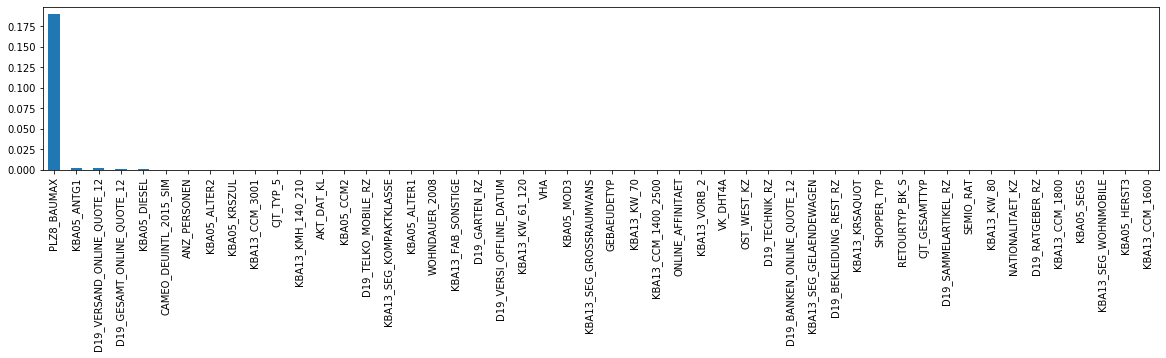

In [39]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df).sum()*100.0/joint_dataset_imputed_df.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

# Second imputation - simple, frequency imputer

In [42]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'most_frequent')

joint_dataset_imputed_df2 = pd.DataFrame(imputer.fit_transform(joint_dataset_imputed_df))

CPU times: user 714 ms, sys: 68.1 ms, total: 782 ms
Wall time: 781 ms


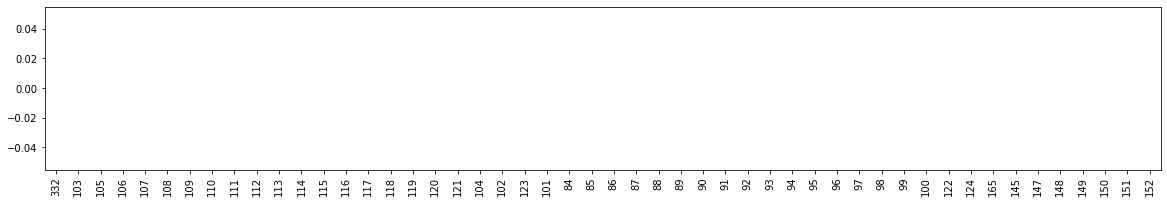

In [43]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df2).sum()*100.0/joint_dataset_imputed_df2.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [44]:
joint_dataset_imputed_df2.to_csv("../arvato_data_processed/joint_dataset_imputed_df2.csv")

In [45]:
joint_dataset_imputed_df2.shape

(932108, 333)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
test = pca.fit_transform(joint_dataset_imputed_df2)

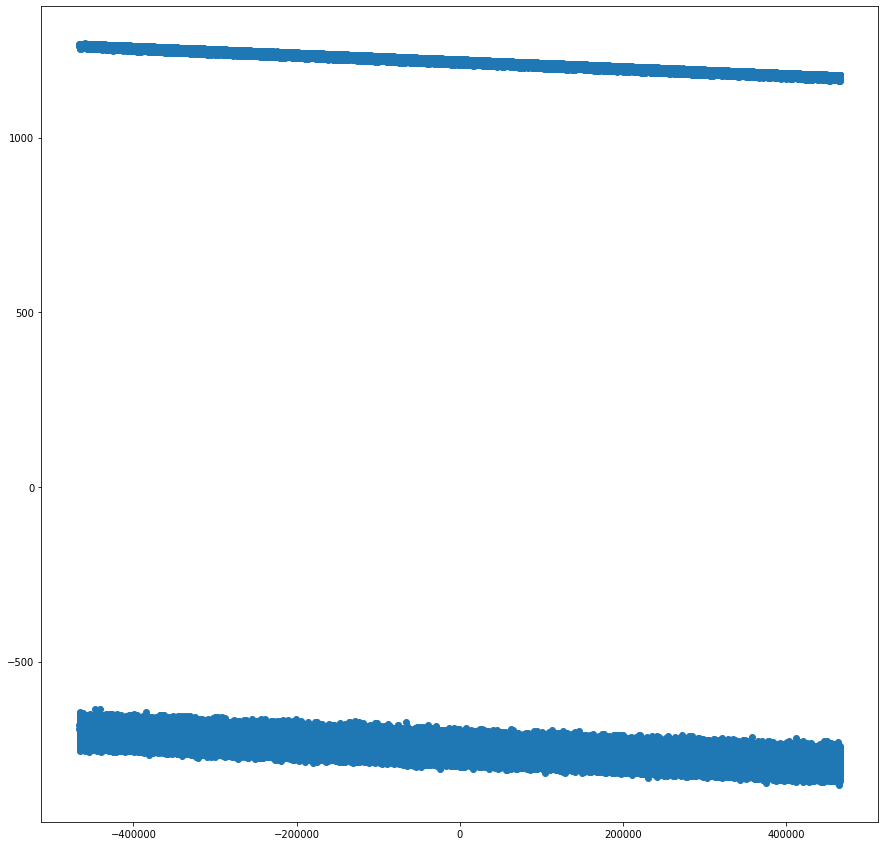

In [51]:
plt.figure(figsize=(15,15))
plt.scatter(test[:,0],test[:,1])